# <a name="0">Machine Learning Accelerator - Computer Vision - Lecture 1</a>

## Neural Networks with Gluon

In this notebook, we build, train and validate a Neural Network in [Gluon](https://mxnet.apache.org/api/python/docs/tutorials/packages/gluon/index.html), a library that provides a clear, concise, and simple API for deep learning. 

1. <a href="#1">Implementing a neural network with Gluon</a>       
2. <a href="#2">Loss Functions</a>
3. <a href="#3">Training</a>
4. <a href="#4">Example - Binary Classification</a>
    

## 1. <a name="1">Implementing a neural network with Gluon</a>
(<a href="#0">Go to top</a>)

Let's implement a simple neural network with two hidden layers of size 64 using the sequential mode (Adding things in sequence). We will have 3 inputs, 2 hidden layers and 1 output layer. Some drop-outs attached to the hidden layers.

In [12]:
from mxnet.gluon import nn

net = nn.Sequential()

net.add(nn.Dense(64,                    # Dense layer-1 with 64 units
#                  in_units=3,            # Input size of 3 is expected
                 activation='tanh'),    # Tanh activation is applied
        nn.Dropout(.4),                 # Apply random 40% drop-out to layer_1
        
        nn.Dense(64,                   # Dense layer-2 with 64 units  
                 activation='tanh'),    # Tanh activation is applied
                
        nn.Dropout(.3),                 # Apply random 30% drop-out to layer_2
        
        nn.Dense(1))                    # Output layer with single unit

print(net)

Sequential(
  (0): Dense(None -> 64, Activation(tanh))
  (1): Dropout(p = 0.4, axes=())
  (2): Dense(None -> 64, Activation(tanh))
  (3): Dropout(p = 0.3, axes=())
  (4): Dense(None -> 1, linear)
)


We first randomly initialize the weights parameters of the network with the `initialize()` function. Using these weights as a start, we can later apply optimization such as SGD to train the weights. As a result, using a strategic technique to initialize the weights is crucial. 

Here is a full list of [Initializers](https://mxnet.apache.org/api/python/docs/api/initializer/index.html). The commonly used one is called *Xavier initilaization*, which can keep the scale of gradients roughly the same in all the layers. (Here are more technical details of [Xavier initilaization](https://d2l.ai/chapter_multilayer-perceptrons/numerical-stability-and-init.html#xavier-initialization).) Let's use it in our implementation.

In [13]:
from mxnet import init

net.initialize(init=init.Xavier())

We can easily access them with `net[layer_index]`:

In [14]:
print(net[0])
print(net[1])
print(net[2])
print(net[3])
print(net[4])

Dense(None -> 64, Activation(tanh))
Dropout(p = 0.4, axes=())
Dense(None -> 64, Activation(tanh))
Dropout(p = 0.3, axes=())
Dense(None -> 1, linear)


## 2. <a name="2">Loss Functions</a>
(<a href="#0">Go to top</a>)

We can select [loss functions](https://d2l.ai/chapter_linear-networks/linear-regression.html#loss-function) according to our problem. A full list of supported `Loss` functions in Gluon are available [here](https://mxnet.incubator.apache.org/api/python/docs/api/gluon/loss/index.html). 

Let's go over some popular loss functions and see how to call a built-in loss function:


__Binary Cross-entropy Loss:__ A common used loss function for binary classification. 

```python
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss
loss = SigmoidBinaryCrossEntropyLoss()
```

__Categorical Cross-entropy Loss:__ A common used loss function for multi-class classification. 

```python
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss
loss = SoftmaxCrossEntropyLoss()
```

__L2 Loss:__ A most common used loss function for regression problems. 

```python
from mxnet.gluon.loss import L2Loss
loss = L2Loss()
```

## 3. <a name="3">Training</a>
(<a href="#0">Go to top</a>)

`mxnet.gluon.Trainer()` module provides necessary training algorithms for neural networks. We can use the following `Trainer` to train a network using [Stochastic Gradient Descent (SGD)](https://d2l.ai/chapter_optimization/sgd.html) method and learning rate of 0.001.

```python
from mxnet import gluon

trainer = gluon.Trainer(net.collect_params(),
                        'sgd', 
                        {'learning_rate': 0.001}
                       )
```

## 4. <a name="4">Example - Binary Classification</a>
(<a href="#0">Go to top</a>)

In this example, we will train a neural network on a dataset that we randomly generated. We will have two classes and train a neural network to classify them.

In [15]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=750, shuffle=True, random_state=42, noise=0.05, factor=0.3)

First let's plot the simulated dataset.

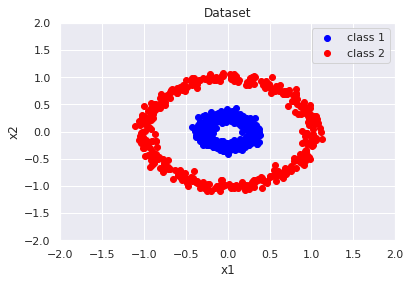

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dataset(X, y, title):
    
    # Activate Seaborn visualization
    sns.set()
    
    # Plot both classes: Class1->Blue, Class2->Red
    plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', label="class 1")
    plt.scatter(X[y==0, 0], X[y==0, 1], c='red', label="class 2")
    plt.legend(loc='upper right')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.title(title)
    plt.show()
    
plot_dataset(X, y, title="Dataset")

Next, we import the necessary libraries and classes.

In [17]:
import time
import mxnet as mx
from mxnet import gluon, autograd
import mxnet.ndarray as nd
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss

Then, we create the network as below. It will have two hidden layers. Since the data seems easily seperable, we can have a small network (2 hidden layers) with 10 units at each layer.

In [18]:
from mxnet import init
from mxnet.gluon import nn

context = mx.cpu()       # Using CPU resource; mx.gpu() will use GPU resources if available
net = nn.Sequential()
net.add(nn.Dense(10, in_units=2, activation='relu'),
        nn.Dense(10, activation='relu'),
        nn.Dense(1, activation='sigmoid'))
net.initialize(init=init.Xavier(), ctx=context)

Now let's prepare the training set and validation set, and load each of them to a `DataLoader`, respectively.

In [19]:
# Split the dataset into two parts: 80%-20% split
X_train, X_val = X[0:int(len(X)*0.8), :], X[int(len(X)*0.8):, :]
y_train, y_val = y[:int(len(X)*0.8)], y[int(len(X)*0.8):]

# Use Gluon DataLoaders to load the data in batches
batch_size = 4           # How many samples to use for each weight update 
train_dataset = gluon.data.ArrayDataset(nd.array(X_train), nd.array(y_train))
train_loader = gluon.data.DataLoader(train_dataset, batch_size=batch_size)

# Move validation dataset in CPU/GPU context
X_val = nd.array(X_val).as_in_context(context)
y_val = nd.array(y_val).as_in_context(context)

Before the training, one last thing is to define the hyper-parameters for training.

In [20]:
epochs = 50              # Total number of iterations
learning_rate = 0.01     # Learning rate

# Define the loss. As we used sigmoid in the last layer, use from_sigmoid=True
binary_cross_loss = SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)

# Define the trainer, SGD with learning rate
trainer = gluon.Trainer(net.collect_params(),
                        'sgd',
                        {'learning_rate': learning_rate}
                       )

Finally, it is the time for training! We will run through the training set 50 times (i.e., epochs) and print training and validation losses at each epoch.

In [21]:
import time

train_losses = []
val_losses = []
for epoch in range(epochs):
    start = time.time()
    training_loss = 0
    # Build a training loop, to train the network
    for idx, (data, target) in enumerate(train_loader):

        data = data.as_in_context(context)
        target = target.as_in_context(context)
        
        with autograd.record():
            output = net(data)
            L = binary_cross_loss(output, target)
            training_loss += nd.sum(L).asscalar()
            L.backward()
        trainer.step(data.shape[0])
    
    # Get validation predictions
    val_predictions = net(X_val)
    # Calculate the validation loss
    val_loss = nd.sum(binary_cross_loss(val_predictions, y_val)).asscalar()
    
    # Take the average losses
    training_loss = training_loss / len(y_train)
    val_loss = val_loss / len(y_val)
    
    train_losses.append(training_loss)
    val_losses.append(val_loss)
    
    end = time.time()
    # Print the losses every 10 epochs
    if (epoch == 0) or ((epoch+1)%10 == 0):
        print("Epoch %s. Train_loss %f Validation_loss %f Seconds %f" % \
              (epoch, training_loss, val_loss, end-start))

Epoch 0. Train_loss 0.678864 Validation_loss 0.668923 Seconds 0.560747
Epoch 9. Train_loss 0.452109 Validation_loss 0.439064 Seconds 0.446111
Epoch 19. Train_loss 0.148139 Validation_loss 0.144847 Seconds 0.487933
Epoch 29. Train_loss 0.067387 Validation_loss 0.067389 Seconds 0.466043
Epoch 39. Train_loss 0.041224 Validation_loss 0.041660 Seconds 0.555821
Epoch 49. Train_loss 0.029123 Validation_loss 0.029645 Seconds 0.447719


Let's see the training and validation loss plots below. Losses go down as the training process continues as expected.

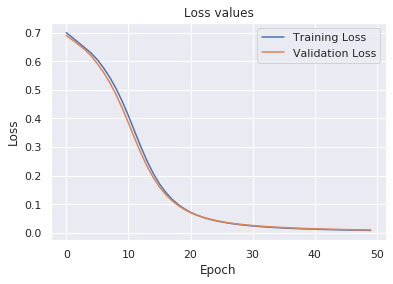

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()